<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction


**What?** Moving average model



# Moving average model


- The residual errors from forecasts on a time series provide another source of information that we can model.
- Residual errors themselves form a time series that can have temporal structure. 
- A simple autoregression model  of this structure can be used to predict the forecast error, which in turn can be used to correct forecasts.
- This type of model is called a **moving average model**, the same name but very different from moving average smoothing.



# Import modules

In [2]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.ar_model import AR
from matplotlib import pyplot, rcParams

# Import dataset

In [3]:
series = read_csv('../DATASETS/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# Persistent model


- The simplest forecast that we can make is to forecast that what happened in the previous time step will be the same as what will happen in the next time step. 
- This is called the naive forecast or the persistence forecast model.
- This model will provide the predictions from which we can calculate the residual error time series.



In [4]:
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
predictions = [x for x in test_X]

# skill of persistence model
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))] 
residuals = DataFrame(residuals)
print(residuals.head())

Test RMSE: 9.151
      0
0   9.0
1 -10.0
2   3.0
3  -6.0
4  30.0


# Autoregression of residual error


- We can model the residual error time series using an autoregression model. 
- This is a linear regression model that creates a weighted linear sum of lagged residual error terms.



In [6]:
# persistence model on training set
train_pred = [x for x in train_X]

# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))] # model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('Lag=%d, Coef=%s' % (window, coef))

Lag=15, Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]



- The autoregression model requires the residual error of the 15 previous time steps. 
- Therefore, we must keep these values handy. 
- As we step through the test dataset timestep by timestep making predictions and estimating error, we can then calculate the actual residual error and update the residual error time series lag values (history) so that we can calculate the error at the next time step. 
- This is a walk forward forecast, or a rolling forecast, model.
- We end up with a time series of the residual forecast error from the train dataset and a predicted residual error on the test dataset. 



In [7]:
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))] # model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    print('predicted error=%f, expected error=%f' % (pred_error, error))

predicted error=1.155523, expected error=9.000000
predicted error=-7.108809, expected error=-10.000000
predicted error=3.007486, expected error=3.000000
predicted error=-0.756446, expected error=-6.000000
predicted error=5.511163, expected error=30.000000
predicted error=-19.991264, expected error=-28.000000
predicted error=4.842429, expected error=2.000000
predicted error=3.050883, expected error=9.000000
predicted error=-5.141585, expected error=-7.000000
predicted error=1.161119, expected error=1.000000
predicted error=-0.241928, expected error=-9.000000
predicted error=9.159826, expected error=21.000000
predicted error=-7.117974, expected error=-13.000000
predicted error=1.182992, expected error=-2.000000
predicted error=2.769363, expected error=11.000000
predicted error=-4.959337, expected error=-11.000000
predicted error=2.566233, expected error=-8.000000
predicted error=9.084498, expected error=6.000000
predicted error=3.020899, expected error=16.000000
predicted error=-6.542098

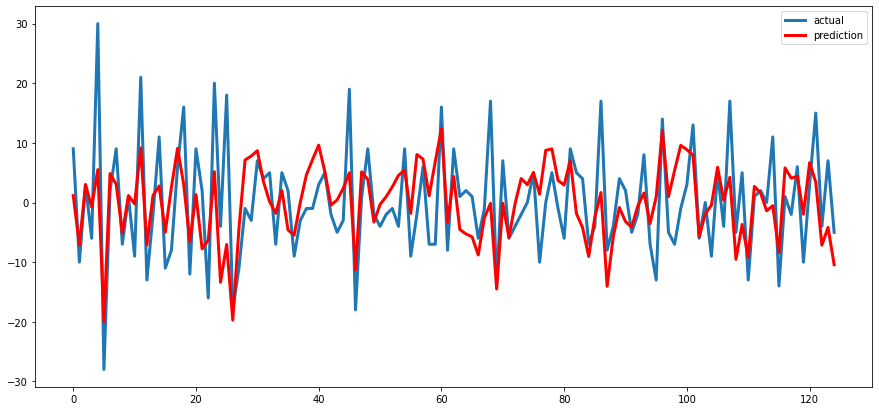

In [12]:
# plot predicted error
pyplot.plot(expected_error, lw = 3, label = "actual") 
pyplot.plot(predictions, color='red', lw = 3, label = "prediction") 
rcParams['figure.figsize'] = 15, 7
pyplot.legend()
pyplot.show()

# Correct Predictions with a Model of Residuals


- Now that we know how to model residual error, next we will look at how we can go about correcting forecasts and improving model skill.
- A model of forecast residual error is interesting, but it can also be useful to make better predictions. 
- With a good estimate of forecast error at a time step, we can make better predictions. 
- For example, we can add the expected forecast error to a prediction to correct it and in turn improve the skill of the model.
- The RMSE of the corrected forecasts is calculated to be 7.499 births per day, which is **much better** than the score of 9.151 for the persistence model alone.



In [13]:
# persistence model on training set
train_pred = [x for x in train_X]

# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    print('predicted=%f, expected=%f' % (yhat, test_y[t]))

# error
rmse = sqrt(mean_squared_error(test_y, predictions)) 
print('Test RMSE: %.3f' % rmse)

predicted=43.155523, expected=51.000000
predicted=43.891191, expected=41.000000
predicted=44.007486, expected=44.000000
predicted=43.243554, expected=38.000000
predicted=43.511163, expected=68.000000
predicted=48.008736, expected=40.000000
predicted=44.842429, expected=42.000000
predicted=45.050883, expected=51.000000
predicted=45.858415, expected=44.000000
predicted=45.161119, expected=45.000000
predicted=44.758072, expected=36.000000
predicted=45.159826, expected=57.000000
predicted=49.882026, expected=44.000000
predicted=45.182992, expected=42.000000
predicted=44.769363, expected=53.000000
predicted=48.040663, expected=42.000000
predicted=44.566233, expected=34.000000
predicted=43.084498, expected=40.000000
predicted=43.020899, expected=56.000000
predicted=49.457902, expected=44.000000
predicted=45.328116, expected=53.000000
predicted=45.225588, expected=55.000000
predicted=48.705924, expected=39.000000
predicted=44.166344, expected=59.000000
predicted=45.621871, expected=55.000000


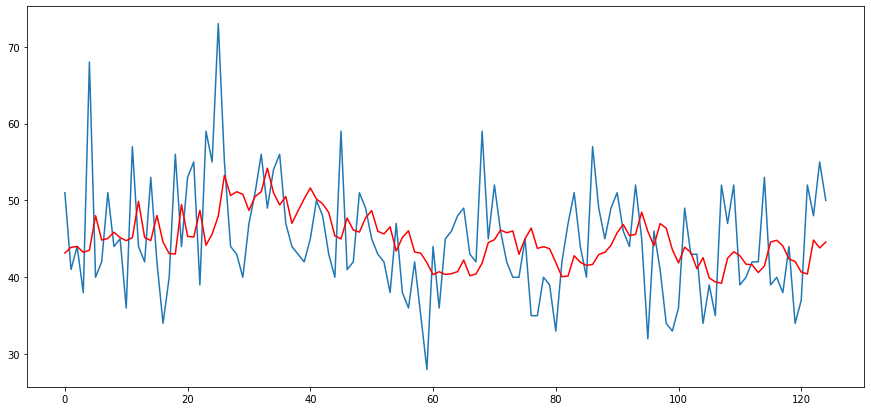

In [15]:
# plot predicted error
pyplot.plot(test_y)
pyplot.plot(predictions, color='red') 
pyplot.show()


- We can see that the persistence model has been AGGRESSIVELY corrected back to a time series that looks something like a moving average.



# References


- https://machinelearningmastery.com/?s=time+series&post_type=post&submit=Search

